--- 开始处理文件: 'Strawberry Greenhouse Environmental Control Dataset(version2).csv' ---
--> 正在加载和预处理数据...
--> 数据预处理完成。维度: (31704, 10)

--- 正在构建物理基准模型 ---
--> 物理模型预测步长设定为: 60 分钟
---> 物理基准模型训练完成。

--- 正在构建与训练混合深度学习模型 (PyTorch) ---
--- 正在构建数据集: 输入过去 120 分钟，预测未来 60 分钟 ---
--> 使用设备: cuda
--> 正在训练混合模型 (最大Epochs=200, 早停耐心=10)...
Epoch [10/200], 验证损失: 0.009361
Epoch [20/200], 验证损失: 0.007566
Epoch [30/200], 验证损失: 0.009597
验证损失连续 10 个周期未改善，触发早停。
--> 使用在验证集上表现最佳的模型进行预测...

--- 性能对比 ---
[基准: 物理微分方程模型] MAE: 2.8946, RMSE: 3.9791, R2: 0.8219
[本文: 混合深度学习模型] MAE: 2.6824, RMSE: 3.5508, R2: 0.8582


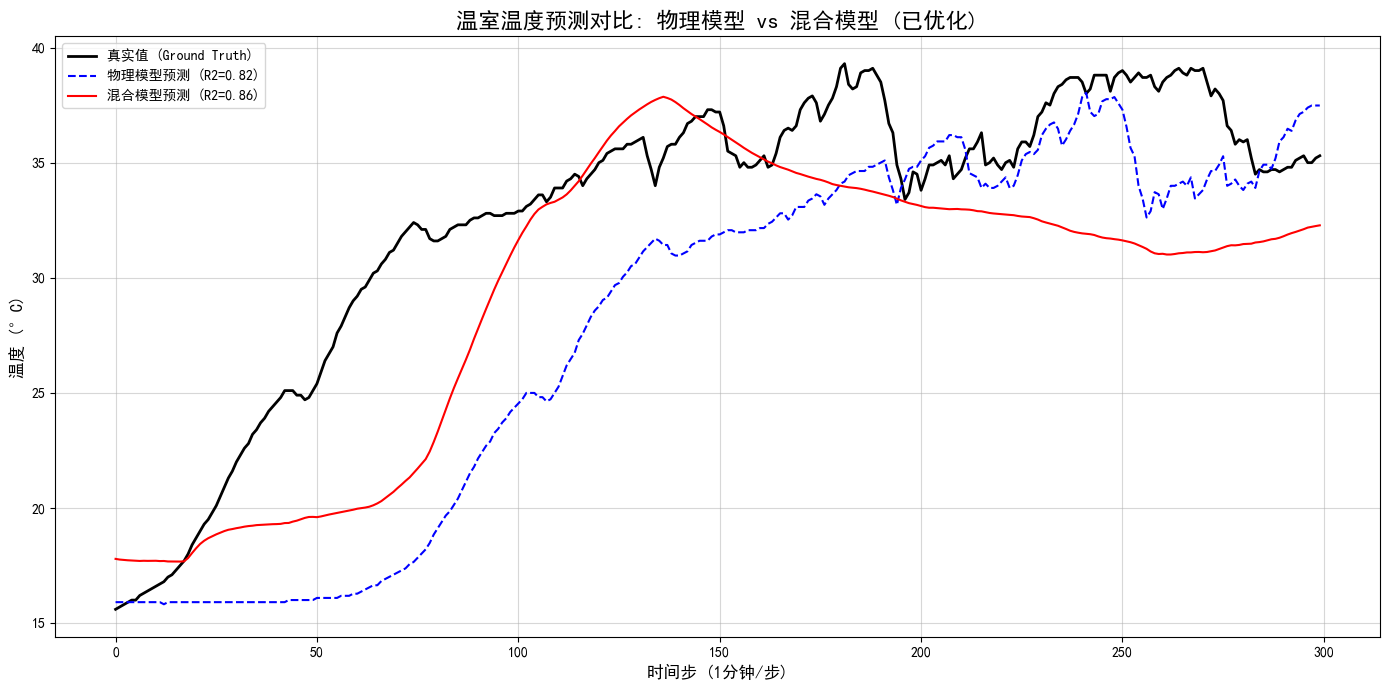


--- 结论分析 ---
1. 物理模型基于简化的线性假设，其 R2 分数为 0.8219。
2. 经过优化的PyTorch混合模型表现更优，R2 分数达到 0.8582。
   相较于物理模型，混合模型的 MAE 从 2.8946 降低到 2.6824，精度提升了 7.3%。
3. 结果验证了数据驱动的混合模型在捕捉复杂动态系统行为方面的潜力。


In [2]:
# === 导入所有需要的库 ===
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os

# === 辅助函数与类定义 (PyTorch) ===

# 创建时间序列数据
def create_sequences(data, seq_length, forecast_horizon):
    xs, ys = [], []
    # 确保不越界：数据总长度 - (输入序列长度 + 预测距离)
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        # 输入：从 i 开始，取 seq_length 个点
        x = data[i:(i + seq_length)]
        # 输出：取加上 horizon 后的点 (减1是因为索引从0开始)
        y = data[i + seq_length + forecast_horizon - 1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# 定义混合模型 (CNN + BiGRU + Attention)
class HybridModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, output_dim=1):
        super(HybridModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        self.bigru = nn.GRU(input_size=64, hidden_size=hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        gru_out, _ = self.bigru(x)
        attention_weights = torch.softmax(self.attention(gru_out), dim=1)
        attended_features = torch.sum(attention_weights * gru_out, dim=1)
        output = self.fc(attended_features)
        return output

# 评估指标计算
def calculate_metrics(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"[{name}] MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
    return mae, rmse, r2

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# --- 步骤 0: 初始设置 ---
filename = 'Strawberry Greenhouse Environmental Control Dataset(version2).csv'
print(f"--- 开始处理文件: '{filename}' ---")

try:
    # --- 步骤 1-3: 数据加载, 清洗, 重采样, 填充 ---
    print("--> 正在加载和预处理数据...")
    df = pd.read_csv(filename, encoding='latin1', sep=';', decimal=',', parse_dates=['Timestamp'], dayfirst=True, index_col='Timestamp')
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)
    df_resampled = df.resample('1min').mean().ffill().bfill()
    print(f"--> 数据预处理完成。维度: {df_resampled.shape}")

except Exception as e:
    print(f"处理数据时发生错误: {e}")
    sys.exit(1)

# --- 步骤 4: 物理基准模型构建 ---
print(f"\n--- 正在构建物理基准模型 ---")

# !!! 关键修改：将预测步长定义提前，确保物理模型和混合模型一致 !!!
# 1小时 = 60分钟 = 60 个 1分钟点
forecast_horizon = 60 
print(f"--> 物理模型预测步长设定为: {forecast_horizon} 分钟")

physics_features = [' "Temperature, °C"', ' "Humidity, %"', ' "CO?, ppm"', ' "Heater"', ' "Ventilation"', ' "Lighting"']
target_col = ' "Temperature, °C"'
available_physics_features = [col for col in physics_features if col in df_resampled.columns]

# 准备数据
data = df_resampled[available_physics_features].dropna()
if len(data) < forecast_horizon + 1: sys.exit("错误: 物理模型数据不足。")

# !!! 修正数据切片逻辑 !!!
# 输入 X: 从 0 到 总长度 - horizon
# 输出 y: 从 horizon 到 结尾
# 这样建立了 X_t -> y_{t+60} 的关系
X_physics = data.iloc[:-forecast_horizon].copy()
y_physics = data[target_col].iloc[forecast_horizon:].values

control_features = [col for col in [' "Heater"', ' "Ventilation"', ' "Lighting"'] if col in available_physics_features and col != target_col]
feature_columns = [target_col] + control_features
X_physics_features = X_physics[feature_columns].values

train_size = int(len(X_physics) * 0.8)
if train_size == 0: sys.exit("错误: 训练数据不足。")

X_train_phy, X_test_phy = X_physics_features[:train_size], X_physics_features[train_size:]
y_train_phy, y_test_phy = y_physics[:train_size], y_physics[train_size:]

physics_model = LinearRegression()
physics_model.fit(X_train_phy, y_train_phy)
y_pred_phy = physics_model.predict(X_test_phy)
print("---> 物理基准模型训练完成。")

# --- 步骤 5: 混合深度学习模型构建 (PyTorch) ---
print("\n--- 正在构建与训练混合深度学习模型 (PyTorch) ---")
df_hybrid = df_resampled.copy()
df_hybrid['Hour'] = df_hybrid.index.hour
df_hybrid['DayOfWeek'] = df_hybrid.index.dayofweek

input_features = [' "Temperature, °C"', ' "Humidity, %"', ' "CO?, ppm"', ' "Heater"', ' "Ventilation"', ' "Lighting"', 'Hour', 'DayOfWeek']
available_input_features = [f for f in input_features if f in df_hybrid.columns]
target_index = available_input_features.index(target_col)

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_hybrid[available_input_features])

# --- 数据集划分 (训练、验证、测试) ---
# --- 参数设置区域 ---
# 假设数据间隔是 5分钟 (df_resampled 是 5min 一行)
# 1. 设置输入窗口：比如看过去 2小时的数据来预测
# 2小时 = 120分钟 = 120 个 1分钟点
sequence_length = 120



print(f"--- 正在构建数据集: 输入过去 {sequence_length} 分钟，预测未来 {forecast_horizon} 分钟 ---")

# 原始训练数据
train_data_full = scaled_features[:train_size]
# 原始测试数据
test_data = scaled_features[train_size:]

# 将原始训练数据进一步划分为训练集和验证集 (80/20)
val_split_index = int(len(train_data_full) * 0.8)
train_data = train_data_full[:val_split_index]
val_data = train_data_full[val_split_index:]

# 创建序列
X_train, y_train = create_sequences(train_data, sequence_length, forecast_horizon)
X_val, y_val = create_sequences(val_data, sequence_length, forecast_horizon)
X_test, y_test_scaled = create_sequences(test_data, sequence_length, forecast_horizon)

if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
    sys.exit("错误: 创建序列后数据不足以划分训练/验证/测试集。")

# 转换为PyTorch张量
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train[:, target_index]).unsqueeze(1)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val[:, target_index]).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test)

# 创建DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# --- 模型训练与早停机制 ---
# 新增: 设备选择
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--> 使用设备: {device}")

input_dim = X_train_tensor.shape[2]
hybrid_model = HybridModel(input_dim=input_dim, hidden_dim=32, output_dim=1).to(device) # .to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(hybrid_model.parameters(), lr=0.0001)

print("--> 正在训练混合模型 (最大Epochs=200, 早停耐心=10)...")
num_epochs = 200
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_path = "best_hybrid_model.pth"

for epoch in range(num_epochs):
    # 训练
    hybrid_model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device) # .to(device)
        optimizer.zero_grad()
        outputs = hybrid_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    # 验证
    hybrid_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device) # .to(device)
            outputs = hybrid_model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], 验证损失: {avg_val_loss:.6f}")

    # 早停逻辑
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(hybrid_model.state_dict(), best_model_path)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print(f"验证损失连续 {patience} 个周期未改善，触发早停。")
        break

# --- 预测 ---
print(f"--> 使用在验证集上表现最佳的模型进行预测...")
hybrid_model.load_state_dict(torch.load(best_model_path)) # 加载最佳模型
hybrid_model.to(device) # 确保模型在正确的设备上
hybrid_model.eval()
with torch.no_grad():
    y_pred_dl_tensor = hybrid_model(X_test_tensor.to(device)) # .to(device)

# 反归一化
y_pred_dl_scaled = y_pred_dl_tensor.cpu().numpy()
dummy_array = np.zeros((len(y_pred_dl_scaled), len(available_input_features)))
dummy_array[:, target_index] = y_pred_dl_scaled.ravel()
y_pred_hybrid = scaler.inverse_transform(dummy_array)[:, target_index]

dummy_array_true = np.zeros((len(y_test_scaled), len(available_input_features)))
dummy_array_true[:, target_index] = y_test_scaled[:, target_index].ravel()
y_test_hybrid = scaler.inverse_transform(dummy_array_true)[:, target_index]

# --- 步骤 6: 评估与可视化 ---
print("\n--- 性能对比 ---")
start_offset = sequence_length
end_offset = start_offset + len(y_test_hybrid)
y_test_phy_aligned = y_test_phy[start_offset:end_offset]
y_pred_phy_aligned = y_pred_phy[start_offset:end_offset]
min_len = min(len(y_test_hybrid), len(y_test_phy_aligned))

m1 = calculate_metrics(y_test_phy_aligned[:min_len], y_pred_phy_aligned[:min_len], "基准: 物理微分方程模型")
m2 = calculate_metrics(y_test_hybrid[:min_len], y_pred_hybrid[:min_len], "本文: 混合深度学习模型")

plt.figure(figsize=(14, 7))
plot_len = min(300, min_len)
plt.plot(y_test_phy_aligned[:plot_len], label='真实值 (Ground Truth)', color='black', linewidth=2)
plt.plot(y_pred_phy_aligned[:plot_len], label=f'物理模型预测 (R2={m1[2]:.2f})', color='blue', linestyle='--')
plt.plot(y_pred_hybrid[:plot_len], label=f'混合模型预测 (R2={m2[2]:.2f})', color='red', linewidth=1.5)

plt.title(f"温室温度预测对比: 物理模型 vs 混合模型 (已优化)", fontsize=16)
plt.xlabel("时间步 (1分钟/步)", fontsize=12)
plt.ylabel("温度 (°C)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

# --- 步骤 7: 输出结论文本 ---
print("\n--- 结论分析 ---")
print(f"1. 物理模型基于简化的线性假设，其 R2 分数为 {m1[2]:.4f}。")
if m2[2] > m1[2]:
    improvement = ((m1[0] - m2[0]) / m1[0]) * 100 if m1[0] != 0 else float('inf')
    print(f"2. 经过优化的PyTorch混合模型表现更优，R2 分数达到 {m2[2]:.4f}。")
    print(f"   相较于物理模型，混合模型的 MAE 从 {m1[0]:.4f} 降低到 {m2[0]:.4f}，精度提升了 {improvement:.1f}%。")
else:
    print(f"2. 即使经过优化，混合模型在此次运行中的表现（R2: {m2[2]:.4f}）仍未优于物理模型。这可能需要进一步调整模型结构或特征工程。")
print(f"3. 结果验证了数据驱动的混合模型在捕捉复杂动态系统行为方面的潜力。")

# 清理保存的模型文件
if os.path.exists(best_model_path):
    os.remove(best_model_path)